# MOM-SIS 0.25$^\circ$ Diagnostics

This notebook calculates and retains key diagnostics from our mom01v5 simulations. The following experiments are included:

| Experiment Name | Description |
|-----------------|-----------------|
|mom025_nyf | Original simulation, rerun from WOA13 initial conditions.|
|mom025_nyf_salt | As above, with new ew salt restoring file from WOA13 surface data. (Not running yet)|

**Last updated May 20 2017.**

### Experiments

In [1]:
DataDir = '/g/data3/hh5/tmp/cosima/mom025'
expts = ['mom025_nyf','mom025_nyf_salt']

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
import pickle

import dask
from dask import delayed
import dask.array as da
import dask.dataframe as dd
from dask.multiprocessing import get
from dask.async import get_sync
from dask.diagnostics import ProgressBar

import pandas as pd
import xarray as xr
from glob import glob
from mpl_toolkits.basemap import Basemap, shiftgrid

#import datashader

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [3]:
pbar = ProgressBar()
pbar.register()

In [4]:
# set up dask to initiate 4 parallel processors.
dask.set_options(get=dask.multiprocessing.get, num_workers=4)

## Wind Stress fields
The following code block shows the zonal- and time-averaged wind stress forcing for each experiment.

[####################################### ] | 98% Completed | 27.2s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 27.3s
[#####################################   ] | 93% Completed |  9.3s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  9.4s
CPU times: user 17 s, sys: 9.86 s, total: 26.9 s
Wall time: 40.4 s


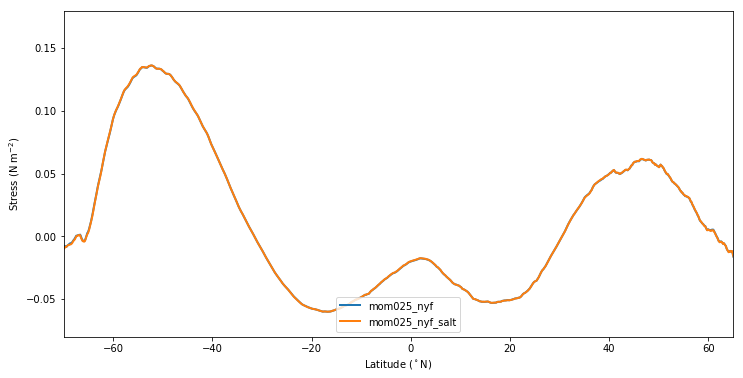

In [5]:
%%time
plt.figure(figsize=(12,6))
for e in expts:
    ExpDir = os.path.join(DataDir,e)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean_month.nc'))
    FileList.sort()
    
    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    
    dsx.tau_x.mean('time').mean('xu_ocean').plot(linewidth=2,label=e)


plt.xlim([-70,65])
plt.ylim([-0.08,0.18])
plt.xlabel('Latitude ($^\circ$N)')
plt.ylabel('Stress (N m$^{-2}$)')
plt.legend(loc=8,fontsize=10)
plt.savefig('figures/WindStress.pdf')

# Major Transports
In this section, we catalogue and save transport diagnostics from each of the major straits.


In [6]:
# location of Drake Passageand Indonesaian straits. 
# Note that these are approximate -- need careful checking!!
StraightDicts = { 'DrakePassage' :  {'xloc':840,'ymin':110,'ymax':250},
              'Lombok' : {'yloc':463,'xmin':140,'xmax':146},
              'Ombai' : {'xloc':174,'ymin':459,'ymax':465},
              'Timor' : {'xloc':176,'ymin':446,'ymax':460},
            }

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3/lib/python3.5/site-packages/xarray/conventions.py:389: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
1
[########################################] | 100% Completed |  9.2s
2
[########################################] | 100% Completed | 11.3s
3
[########################################] | 100% Completed |  8.7s
4
[########################################] | 100% Completed |  8.9s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
1
[########################################] | 100% Completed |  2.2s
2
[########################################] | 100% Completed |  4.0s
3
[########################################] | 100% Completed |  2.4s
4
[########################################] | 100% Completed |  2.1s


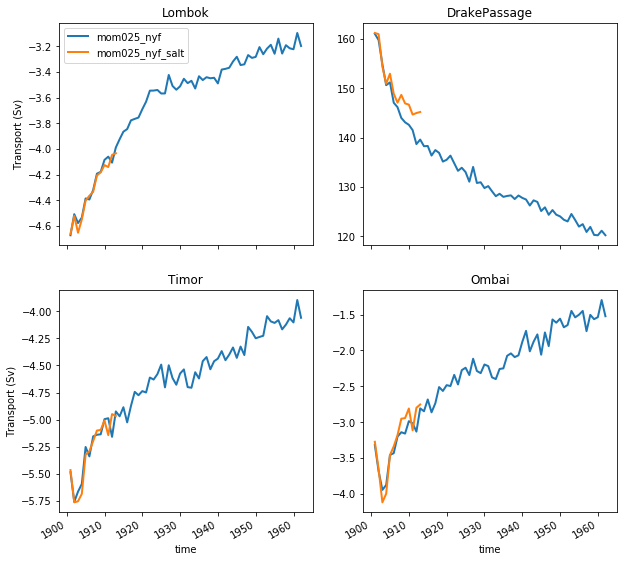

In [7]:
plt.figure(figsize=(10,10))
for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/ocean_month.nc'))
    FileList.sort()
    
    dsx = xr.open_mfdataset(FileList, decode_times=False, engine='netcdf4')
    dsx["time"].attrs["units"] = 'days since 1900-01-01'
    dsx = xr.decode_cf(dsx, decode_times=True)
    nplot = 0
    for straight in StraightDicts:
        nplot+=1
        print(nplot)
        
        TransDict = StraightDicts[straight]
        if 'xloc' in TransDict:
            tx_trans = dsx.tx_trans_int_z[:,TransDict['ymin']:TransDict['ymax'],TransDict['xloc']]
            transport = tx_trans.sum('yt_ocean')
            valrange = tx_trans.valid_range[1]
        elif 'yloc' in TransDict:
            ty_trans = dsx.ty_trans_int_z[:,TransDict['yloc'],TransDict['xmin']:TransDict['xmax']]
            transport = ty_trans.sum('xt_ocean')
            valrange = ty_trans.valid_range[1]
        else:
            transport = np.nan
        
        
        plt.subplot(2,2,nplot)
        transport.resample('a',dim='time').plot(label=expt, linewidth=2)
        #transport.plot(label=expt, linewidth=2)
        
        plt.title(straight)

plt.subplot(221)
plt.legend(loc='upper left')
plt.ylabel('Transport (Sv)')
plt.xlabel('')
plt.subplot(222)
plt.ylabel('')
plt.xlabel('')
plt.subplot(223)
plt.ylabel('Transport (Sv)')
plt.subplot(224)
plt.ylabel('')


plt.savefig('figures/Transports.pdf')

# Scalar Quantities
Look at some quantities that are saved in ocean_scalar.nc.

In [8]:
def extract_data(f):
    dataset = Dataset(f)
    
    data = {}
    for v in dataset.variables.values():
        if 'time' in v.dimensions and 'scalar_axis' in v.dimensions:
            data[v.name] = v[:].flatten()
    index = pd.to_datetime(dataset['time'][:], unit='D')
    df = pd.DataFrame(index=index, data=data)
    return df

scalar_quantities = {}

for expt in expts:
    expdir = os.path.join(DataDir,expt)
    DataFileList = glob(os.path.join(expdir, 'output*/ocean_scalar.nc'))

    frames = [ delayed(extract_data)(f) for f in DataFileList]
    if len(frames) > 0:
        scalar_quantities[expt] = delayed(pd.concat)(frames).compute(num_workers=4)

[########################################] | 100% Completed |  1.9s
[########################################] | 100% Completed |  0.7s


CPU times: user 619 ms, sys: 1.04 s, total: 1.66 s
Wall time: 582 ms


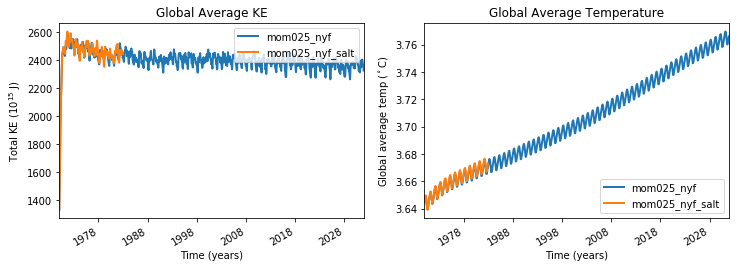

In [9]:
%%time

plt.figure(figsize=(12,4))

for expt in expts:
    plt.subplot(121)
    scalar_quantities[expt].ke_tot.plot(label=expt, linewidth=2)

    plt.subplot(122)
    scalar_quantities[expt].temp_global_ave.plot(label=expt, linewidth=2)

plt.subplot(121)
plt.legend(loc='upper right')
plt.ylabel('Total KE (10$^{15}$ J)')
plt.xlabel('Time (years)')
plt.title('Global Average KE')

plt.subplot(122)
plt.legend(loc='lower right')
plt.ylabel('Global average temp ($^\circ$C)')
plt.xlabel('Time (years)')
plt.title('Global Average Temperature')

plt.savefig('figures/Scalars.pdf')

# Overturning Circulation
Next, let's look at overturning circulation in density space using ty_trans_rho. We will zonally average this diagnostic, without accounting for the tripolar grid, so ignore the Arctic.

In [10]:
def calculate_Ψ(expt, count = 4):
    ExpDir = os.path.join(DataDir, expt)

    FileList = glob(os.path.join(ExpDir, 'output*/ocean.nc'))
    FileList.sort()

    Ψ = 0
    for OceanFile in FileList[-count:]: 
        ## I am having trouble with chunking, so have opted for the slower non-chunking option until
        ## we can find a fix. -- AH 8/4/17.
        dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
        #dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4', chunks={'potrho':5})
        
        psi_partial = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
        dsx.close()

        Ψ = Ψ + psi_partial

    Ψ_avg = Ψ/count

    return Ψ_avg


In [11]:
def plot_psi(psi, expt, clev=np.arange(-20,20,2)):
    #x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

    plt.contourf(psi.grid_yu_ocean, psi.potrho, psi, cmap=plt.cm.PiYG,levels=clev,extend='both')
    cb=plt.colorbar(orientation='vertical', shrink = 0.7)
    cb.ax.set_xlabel('Sv')
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi.grid_yu_ocean, psi.potrho, psi, levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    #plt.gca().yaxis.set_major_formatter(x_formatter)
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    plt.title('Overturning in %s' % expt)

In [12]:
%%time
## One of our problems here is that the zonal sum and density-wise cumulative sum in calculate_Ψ is so slow.
## A possible work-around is to calculate them once, save as a netCDF file, and then simply read in multiple
## netcdf files when it is time to average them, or to construct timeseries.

## Here is a first cut of doing that ... 

for expt in expts:
    # Find list of output directories
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*'))
    FileList.sort()
    
    for fn in FileList:
        MOCFile = os.path.join(fn, 'overturning.nc')
    
        # Have I Processed this one yet?
        if not os.path.exists(MOCFile):
            OceanFile = os.path.join(fn, 'ocean.nc')
            if os.path.exists(OceanFile):
                dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
                psi = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
                dsx.close()
                psi.to_netcdf(MOCFile, mode='w', engine='netcdf4')
                print('Saved ', MOCFile)

Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output059/overturning.nc
Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output060/overturning.nc
Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf/output061/overturning.nc
Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output009/overturning.nc
Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output010/overturning.nc
Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output011/overturning.nc
Saved  /g/data3/hh5/tmp/cosima/mom025/mom025_nyf_salt/output012/overturning.nc
CPU times: user 32.1 s, sys: 5.8 s, total: 37.8 s
Wall time: 38.8 s


[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.3s


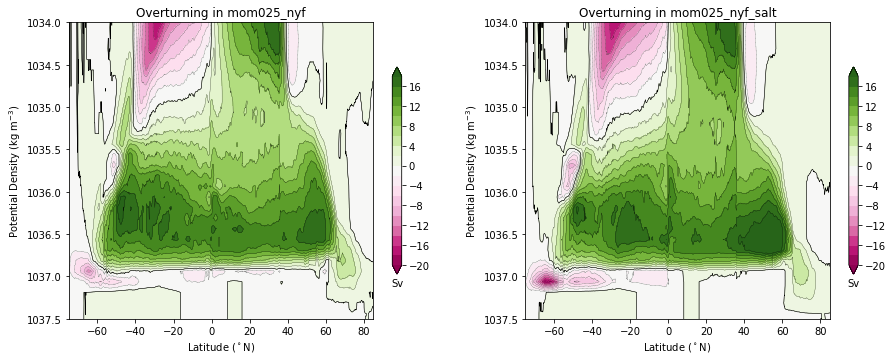

In [13]:
plt.figure(figsize=(15,12)) 
nplot = 0
for expt in expts: 
    nplot += 1
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/overturning.nc'))
    FileList.sort()

    plt.subplot(2,2,nplot)
    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    plot_psi(dsx.ty_trans_rho[-12:,:,:].mean('time'), expt)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


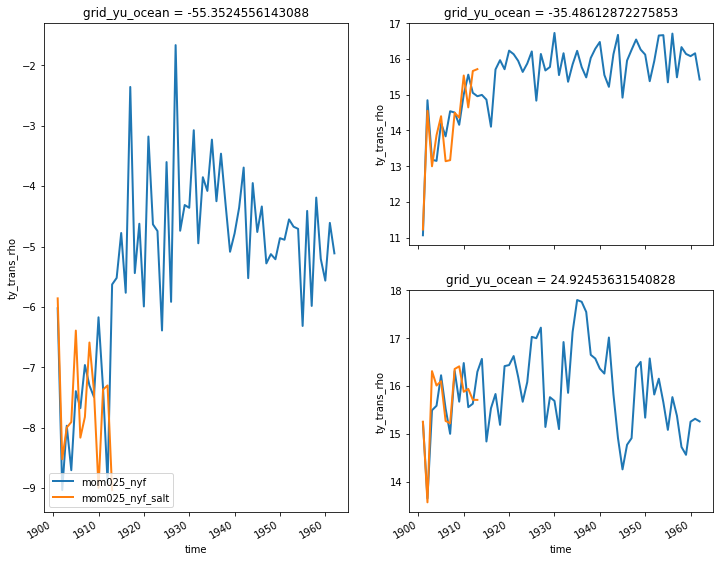

In [14]:
# plot timeseries of overturning
plt.figure(figsize=(12,10))
for expt in expts:
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/overturning.nc'))
    FileList.sort()

    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    dsx.time.attrs["units"] = 'days since 1900-01-01'
    dsx = xr.decode_cf(dsx, decode_times=True)
    
    plt.subplot(121)
    dsx.ty_trans_rho[:,60:,230].min('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    ## still need to check sensitivity to the exaction location in the line above
    
    #Southern branch of the AMOC at 35S
    plt.subplot(222)
    dsx.ty_trans_rho[:,60:,345].max('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    
    # AMOC at 26N
    plt.subplot(224)
    dsx.ty_trans_rho[:,60:,600].max('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 

#plt.title('AABW cell at 60S')
plt.subplot(121)
plt.legend(loc='lower left')